In [14]:
initial_path = 'peptide-QML'
# initial_path = '..'

In [15]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import helper_classes as c
from my_code import pytorch_model as m
from my_code import quantum_nodes as q

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# name of the notebook
name_notebook = "sweep_6h_er_Aqm"

In [17]:
# sweep = c.Sweep(
#     name_notebook, 
#     initial_path=initial_path,
#     description="(6aa, 6q) Try to find best number of q. layers (embedding and block) and type of Anzatz.",
#     repetitions=list(range(1, 4)),
#     block_n_layers=[25,30,40,50,100],
#     embedding_n_layers=[0,1,2,3,4],
#     ansatz=[q.parts.Ansatz_full_conn, q.parts.Ansatz_11],
# )

In [23]:
# sweep.save()

In [21]:
sweep = c.Sweep.load(file_name=name_notebook+"-4", day='0927', initial_path=initial_path)



 --- SWEEP POINT 1/150: (1, 25, 0, <class 'my_code.quantum_nodes.parts.Ansatz_full_conn'>) ---
 --- parameters sweeping: ['repetitions', 'block_n_layers', 'embedding_n_layers', 'ansatz'] 



Epoch [0/20], Loss epoch: 19.9644, Loss validation: 30.0255
	 Validation string, 	 i: 43; 	 prediction: 0.5046, 	 target: 4.5700, 	 loss: 16.5273
	 Validation string, 	 i: 13; 	 prediction: 0.6318, 	 target: -1.0300, 	 loss: 2.7616
	 Validation string, 	 i: 11; 	 prediction: 0.4136, 	 target: 3.0600, 	 loss: 7.0032
Epoch [1/20], Loss epoch: 16.1079, Loss validation: 16.2623, Time remaining: ~0.0h 17.0m 29s
	 Validation string, 	 i: 17; 	 prediction: -5.9425, 	 target: -10.6100, 	 loss: 21.7851
	 Validation string, 	 i: 44; 	 prediction: -4.4149, 	 target: -8.9600, 	 loss: 20.6582
	 Validation string, 	 i: 4; 	 prediction: -1.4299, 	 target: -3.9600, 	 loss: 6.4013
Epoch [2/20], Loss epoch: 9.4722, Loss validation: 8.8174, Time remaining: ~0.0h 14.0m 55s
	 Validation string, 	 i: 7; 	 prediction: 0.1910, 	 target: -2.9300, 	 loss: 9.7409
	 Validation string, 	 i: 7; 	 prediction: 0.1910, 	 target: -2.9300, 	 loss: 9.7409
	 Validation string, 	 i: 17; 	 prediction: -3.8443, 	 target: -10

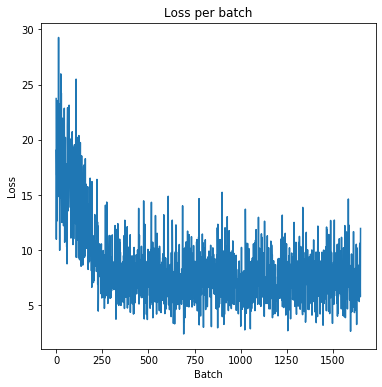

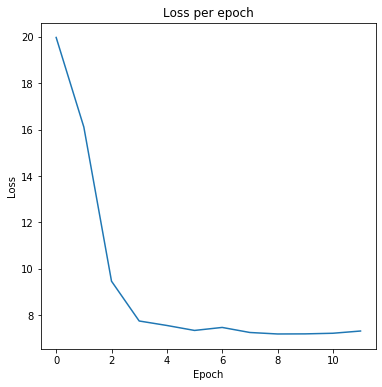

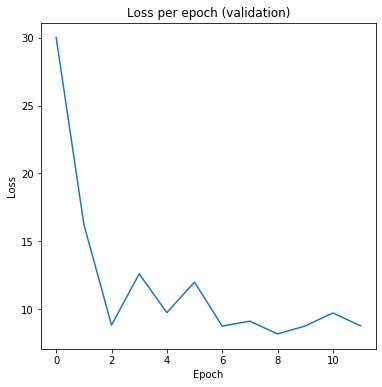

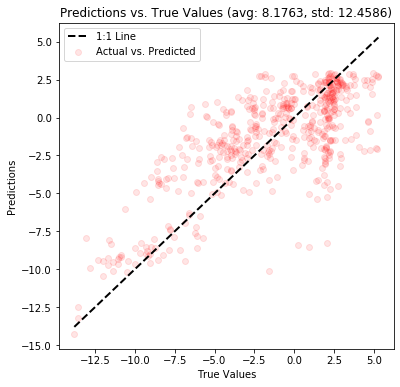

Mean loss: 8.176328532381472, std loss: 12.458576673846663
Folder 'peptide-QML/saved/Results/0927/' created successfully.


 --- SWEEP POINT 2/150: (1, 25, 0, <class 'my_code.quantum_nodes.parts.Ansatz_11'>) ---
 --- time reamining: 23:57:34.88 

Epoch [0/20], Loss epoch: 19.0095, Loss validation: 27.7501
	 Validation string, 	 i: 34; 	 prediction: -0.3589, 	 target: -2.9500, 	 loss: 6.7139
	 Validation string, 	 i: 23; 	 prediction: 0.0552, 	 target: -0.6700, 	 loss: 0.5259
	 Validation string, 	 i: 5; 	 prediction: -6.7303, 	 target: -10.8400, 	 loss: 16.8892
Epoch [1/20], Loss epoch: 13.3201, Loss validation: 12.4229, Time remaining: ~0.0h 23.0m 52s


KeyboardInterrupt: 

In [20]:
for sweep_point in sweep.points_left:

    # print the point of the sweep
    sweep.print_sweep_status(sweep_point['idx'])

    # -- QUANTUM BLOCK -- #
    n_qubits = 6
    quantum_layer = q.circuit(
        n_qubits = n_qubits, 
        device = "default.qubit.torch",
        device_options = {'shots': None},
        embedding = q.parts.AngleEmbedding,
        embedding_ansatz = sweep_point['ansatz'],
        block_ansatz = sweep_point['ansatz'],
        final_ansatz = sweep_point['ansatz'], 
        measurement = q.parts.Measurement('Z', 'all'),
        embedding_n_layers = sweep_point['embedding_n_layers'],
        different_inputs_per_layer = False,
        block_n_layers = sweep_point['block_n_layers'],
        # wrapper_qlayer = pw.QLayerEmpty,
    )

    # -- MODEL -- #                    
    class Model(m.Model):
        def __init__(self):
            super(Model, self).__init__()
            self.fc1 = m.nn.Embedding(num_embeddings=19, embedding_dim=1)
            self.fc2 = m.Reshape()
            self.fc3 = quantum_layer()            
            self.fc4 = m.nn.Linear(n_qubits, 1)

        def forward(self, x):
            for i in [1,2,3,4]:
                x = getattr(self, 'fc{}'.format(i))(x)
            return x

    model = Model()

    # set quantum layer
    model.set_quantum_layer(quantum_layer)

    # set the name and path of the model
    model.set_name_and_path(name_notebook, initial_path)

    #set sweep point
    model.set_sweep_point(
        sweep_uuid = sweep.uuid,
        sweep_point = sweep_point,
        day=sweep.day
    )

    # -- TRAIN -- #
    model.optimize_params(
        #save info
        save_model_info = True,
        description = 'sweep with 6 aa and 6 q -> Try to find best number of q. layers (embedding and block) and type of Anzatz.',    
        #data
        data=c.Data.load(initial_path=initial_path, file_name='PE_SCORES_6_Numbers'),
        # train options
        optimizer = m.optim.Adam,
        optimizer_options = {'lr': 0.01},
        num_epochs = 20,                
        batch_size = 32,
        # early stopping options
        stop_training_options = {
            'lookback_epochs': 5, 
            'threshold_slope': 0.001,
            'threshold_std_dev': 0.2
        },
        # metadata
        metadata = {}
    )

    # -- VALIDATION and PLOTS -- #
    model.plot_losses(fig_size=(6,6))
    model.validate(
        pct=1,
        add_to_results=True,
        plot=True,
        print_items=False
    )

    # -- SAVE RESULTS -- #
    model.save_results()

    # -- ADD DATA GENERATED TO SWEEP -- #
    sweep.add_data(
        idx=sweep_point['idx'],
        model_uuid=model.uuid,
        best_loss_train=model.results.loss_epoch.best,
        best_loss_test=model.results.loss_validation_epoch.best,
        loss_validation=model.mean_loss_validation,
        n_parameters=model.n_parameters,
        time_train=model.results.time_epoch.last,
    )
    sweep.save(csv=False) #TODO: save csv=False automatically when sweep is already saved ion csv

    